# Detecting Diabetes: Data Cleaning and EDA

### Problem Statement:

Diabetes is one of the main causes of death in the United States. Identifying and predicting this disease in individuals is the first step towards stopping its progression. In this project, we want to identify features that can be added to a health app that predicts diabetes and recommends interventions to individuals based on the outcome. We evaluate the capabilities of machine learning models in detecting at-risk individuals using survey data (and physical examination results), and identify key variables within the data contributing to this disease among the participants. The model will be evaluated based on recall and accuracy. 


**Project Objective:**
+ We want to classify people as likely to suffer from diabetes or not based on their demographics, physical activity, body measures, family diabetes history, and income 


#### The data:

National health and nutrition examination survey (NHANES) dataset used in this project is a combined NHANES data from 2019 - March, 2020, and NHANES 2017-2018 cycle to form a nationally representative sample of NHANES 2017 - March 2020 pre-pandemic data. We have used demographics, examination and questionnaire data from this dataset for our analysis. 

1. Demographics data: we looked at age, gender, race, and income
2. Examination data: we looked at: 
        + blood pressure (systolic and diastolic)
        + body measurements (BMI, hip, waist)

3. Questionnaire data: 
        + smoking - cigarette use, 
        + reproductive health (no. of pregnancies), 
        + medical condition (family history)
        + physical activity 
        + diet
- Body mass index (BMI) is a person’s weight in kilograms divided by the square of height in meters. BMI is an inexpensive and easy screening method for weight category—underweight, healthy weight, overweight, and obesity. BMI does not measure body fat directly, but BMI is moderately correlated with more direct measures of body fat 1,2,3. Furthermore, BMI appears to be as strongly correlated with various metabolic and disease outcome as are these more direct measures of body fatness 4,5,6,7,8,9.

## Import Libraries

In [54]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from functools import reduce
from plotnine import *

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import random
random.seed(42)

## Load Data

In [55]:
# read in demographics data
demo = pd.read_sas('./data/P_DEMO.XPT')

# read in questionnaire data
smo_q = pd.read_sas('./data/P_SMQ.XPT')
rep_q= pd.read_sas('./data/P_RHQ.XPT')
di_q= pd.read_sas('./data/P_DIQ.XPT')
medical_q = pd.read_sas('./data/P_MCQ.XPT')
physical_q = pd.read_sas('./data/P_PAQ.XPT')
bp_q = pd.read_sas('./data/P_BPQ.XPT')

# read in examination data
body=pd.read_sas('./data/P_BMX.XPT')
bp=pd.read_sas('./data/P_BPXO.XPT')

## Data Cleaning

___ 
#### Merge dataframes
+ We will merge features from each datasets which could be important in predicting diabetes. Here we will use full outer join to produce all records when there is a match between each of the dataframes. We will use validate to make sure merge keys are unique in both left and right DataFrames.

In [56]:
# look at the shape of the dataframes
dataset=[demo, smo_q, body, bp, rep_q, di_q, medical_q, physical_q, bp_q]
for data in dataset:
    print(data.shape)

(15560, 29)
(11137, 16)
(14300, 22)
(11656, 12)
(5314, 32)
(14986, 28)
(14986, 63)
(9693, 17)
(10195, 11)


Reproductive health questionnarie has a lower number of observations compared to other data

In [57]:
# merge dataframes using sequence numbers of respondents using full outer join  
dfs = [demo, smo_q, body, bp, rep_q, di_q, medical_q, physical_q, bp_q]
df_merged = reduce(lambda left,right: pd.merge(left,right,on='SEQN', how = 'outer', validate='1:1'), dfs)

In [58]:
# check the shape of the merged dataframe
df_merged.shape

(15560, 222)

In [59]:
# create a dataframe with important features from
df = df_merged[['PAQ650','PAQ605','PAQ620', 'PAQ635','PAQ665'
                ,'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'INDFMPIR', 'BMXBMI', 'BMXWAIST'
                ,'BMXHIP', 'BPXOSY2', 'BPXODI2','DIQ010','MCQ300C', 'SMQ040', 'RHQ160', 'BPQ020']]
df.head()

,PAQ650,PAQ605,PAQ620,PAQ635,PAQ665,RIAGENDR,RIDAGEYR,RIDRETH3,INDFMPIR,BMXBMI,BMXWAIST,BMXHIP,BPXOSY2,BPXODI2,DIQ010,MCQ300C,SMQ040,RHQ160,BPQ020
0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,6.0,4.66,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2.0,13.0,1.0,0.83,17.6,63.8,85.0,109.0,68.0,2.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.0,2.0,3.0,3.06,15.0,41.2,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
3,1.0,2.0,2.0,2.0,1.0,2.0,29.0,6.0,5.00,37.8,117.9,126.1,99.0,55.0,2.0,1.0,NaN,NaN,2.0
4,1.0,2.0,2.0,2.0,2.0,2.0,21.0,2.0,5.00,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0


In [60]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15560 entries, 0 to 15559
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PAQ650    9693 non-null   float64
 1   PAQ605    9693 non-null   float64
 2   PAQ620    9693 non-null   float64
 3   PAQ635    9693 non-null   float64
 4   PAQ665    9693 non-null   float64
 5   RIAGENDR  15560 non-null  float64
 6   RIDAGEYR  15560 non-null  float64
 7   RIDRETH3  15560 non-null  float64
 8   INDFMPIR  13359 non-null  float64
 9   BMXBMI    13137 non-null  float64
 10  BMXWAIST  12574 non-null  float64
 11  BMXHIP    9862 non-null   float64
 12  BPXOSY2   10327 non-null  float64
 13  BPXODI2   10327 non-null  float64
 14  DIQ010    14986 non-null  float64
 15  MCQ300C   9232 non-null   float64
 16  SMQ040    3889 non-null   float64
 17  RHQ160    3412 non-null   float64
 18  BPQ020    10195 non-null  float64
dtypes: float64(19)
memory usage: 2.4 MB


#### Outcome Variable: DIQ010

> The value 9 in the outcome column refers to "Don't know" responses to the question "Dr. told you have Diabetes?". 
The value 3 in the outcome column refers to "Borderline" responses to the question "Dr. told you have Diabetes?". 
Let's drop rows with a value of 9 in the DIQ010 column and borderline will be added to the people having diabetes cateogry.

In [61]:
# check the value count of the outcome column
df['DIQ010'].value_counts()

2.0    13249
1.0     1445
3.0      284
9.0        8
Name: DIQ010, dtype: int64

In [62]:
# lets drop rows with value 9, replace borderline people as diabetic, and 
# drop rows with null values in the outcome column
df = df[df.DIQ010 != 9.0]
df['DIQ010']= df.DIQ010.apply(lambda x: 1 if (x ==1.0 or x==3.0) else 0)
df.dropna(subset= ['DIQ010'], inplace=True)

In [63]:
df['DIQ010'].value_counts(normalize=True)

0    0.888825
1    0.111175
Name: DIQ010, dtype: float64

#### smoking status: SMQ040

The feature SMQ040 from smoking questionarrie data is a response to the question 'Do you now smoke cigarettes?' and we are going to re-arrange the categories and we will create a new category for the missing information.

+ Everyday smokers (category 1) and respondents who smoke some days (category 2) will be categorized as smokers or category 1. 
+ Respondents who don't smoke (category 3) will be category 0.
+ Missing data (respondents for whom we don't have smoking information) will be category 2.

In [64]:
# check the value counts of smoking feature
df['SMQ040'].value_counts()

3.0    2204
1.0    1306
2.0     378
Name: SMQ040, dtype: int64

In [65]:
# re-classify smoking column and fill the null values with category 2
df.loc[(df.SMQ040 == 3.0), 'SMQ040'] = 0.0
df.loc[(df.SMQ040 == 2.0), 'SMQ040'] = 1.0
df['SMQ040'].fillna(value=2.0, inplace=True)

In [66]:
# make sure the categories are created
df['SMQ040'].value_counts()

2.0    11664
0.0     2204
1.0     1684
Name: SMQ040, dtype: int64

In [67]:
# drop rows which have null values in more than half of the number of columns 
df.dropna(thresh=8, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13671 entries, 1 to 15559
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PAQ650    9688 non-null   float64
 1   PAQ605    9688 non-null   float64
 2   PAQ620    9688 non-null   float64
 3   PAQ635    9688 non-null   float64
 4   PAQ665    9688 non-null   float64
 5   RIAGENDR  13671 non-null  float64
 6   RIDAGEYR  13671 non-null  float64
 7   RIDRETH3  13671 non-null  float64
 8   INDFMPIR  11939 non-null  float64
 9   BMXBMI    12758 non-null  float64
 10  BMXWAIST  12374 non-null  float64
 11  BMXHIP    9858 non-null   float64
 12  BPXOSY2   10321 non-null  float64
 13  BPXODI2   10321 non-null  float64
 14  DIQ010    13671 non-null  int64  
 15  MCQ300C   9227 non-null   float64
 16  SMQ040    13671 non-null  float64
 17  RHQ160    3410 non-null   float64
 18  BPQ020    10163 non-null  float64
dtypes: float64(18), int64(1)
memory usage: 2.1 MB


#### Physical Activity Features

- Physical activity features have category 7 and category 9 representing respondents who refused to respond to the questions and who don't know the answer to the question respectively. Let's group these two categories and the missing values into one category (category 0).

- We will also do the same to a feature (MCQ300C) from medical condition questionnaire. i.e. create a category 0 for all of the missing values. 

In [68]:
# re-arrange categories in these columns
cols_list = ['PAQ650', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ665', 'MCQ300C', 'BPQ020']

# loop through list of columns and replace 7 and 9 values with 0
for cols in cols_list:
    df.loc[df[cols] == 7, cols] = 0
    df.loc[df[cols] == 9, cols] = 0

# loop through list of columns and fill null values with category 0
for cols in cols_list:
    df[cols]=df[cols].fillna(0)

#### Number of Pregnancies: RHQ160

Reproductive health questionnaire asked how many times female respondents have been pregnant (RHQ160). Out of 5,314 women, three of them refused to answer and 1902 responses are missing. We can assume that the missing data represents zero pregnancies for the respondents. For male respondents and missing values, we will impute with zero values.

Number of pregnancies should be a whole number so we will change the data type.

In [69]:
# check unique values
df['RHQ160'].unique()

array([nan,  5.,  3.,  6.,  2.,  4.,  1., 11.,  7.,  8.,  9., 10., 77.])

In [70]:
# fill missing values with 0 
df.loc[df['RHQ160'] == 77, 'RHQ160'] = 0
df['RHQ160']=df['RHQ160'].fillna(0)

In [71]:
# fill the null values of numerical columns with mean value
for col in ['INDFMPIR', 'BMXBMI', 'BMXWAIST', 'BMXHIP', 'BPXOSY2', 'BPXODI2']:
    df[col]=df[col].fillna(df[col].mean())

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13671 entries, 1 to 15559
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PAQ650    13671 non-null  float64
 1   PAQ605    13671 non-null  float64
 2   PAQ620    13671 non-null  float64
 3   PAQ635    13671 non-null  float64
 4   PAQ665    13671 non-null  float64
 5   RIAGENDR  13671 non-null  float64
 6   RIDAGEYR  13671 non-null  float64
 7   RIDRETH3  13671 non-null  float64
 8   INDFMPIR  13671 non-null  float64
 9   BMXBMI    13671 non-null  float64
 10  BMXWAIST  13671 non-null  float64
 11  BMXHIP    13671 non-null  float64
 12  BPXOSY2   13671 non-null  float64
 13  BPXODI2   13671 non-null  float64
 14  DIQ010    13671 non-null  int64  
 15  MCQ300C   13671 non-null  float64
 16  SMQ040    13671 non-null  float64
 17  RHQ160    13671 non-null  float64
 18  BPQ020    13671 non-null  float64
dtypes: float64(18), int64(1)
memory usage: 2.1 MB


## Feature Engineering

#### Central Obesity : waist to hip ratio

Scientists have long debated which measure of abdominal fat is the best predictor of health risk, waist size alone or waist-to-hip ratio.The research to date has been mixed. But adding up the evidence from multiple studies suggests that both methods do an equally good job of predicting health risks. Some researchers have found that waist, waist-to-hip ratio, and BMI are all strong predictors of type 2 diabetes.

We are going to create a waist to hip ratio from waist and hip measurements to test if we can use it as a potential predictor of diabetes. 

In [73]:
# waist to hip ratio
df['wh_ratio']= df['BMXWAIST']/df['BMXHIP']

In [74]:
col_list=['PAQ650', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ665', 'RIAGENDR',
       'RIDAGEYR', 'RIDRETH3','DIQ010', 'MCQ300C', 'SMQ040', 'RHQ160', 'BPQ020']
for col in col_list:
    df[col]=df[col].astype(int)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13671 entries, 1 to 15559
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PAQ650    13671 non-null  int64  
 1   PAQ605    13671 non-null  int64  
 2   PAQ620    13671 non-null  int64  
 3   PAQ635    13671 non-null  int64  
 4   PAQ665    13671 non-null  int64  
 5   RIAGENDR  13671 non-null  int64  
 6   RIDAGEYR  13671 non-null  int64  
 7   RIDRETH3  13671 non-null  int64  
 8   INDFMPIR  13671 non-null  float64
 9   BMXBMI    13671 non-null  float64
 10  BMXWAIST  13671 non-null  float64
 11  BMXHIP    13671 non-null  float64
 12  BPXOSY2   13671 non-null  float64
 13  BPXODI2   13671 non-null  float64
 14  DIQ010    13671 non-null  int64  
 15  MCQ300C   13671 non-null  int64  
 16  SMQ040    13671 non-null  int64  
 17  RHQ160    13671 non-null  int64  
 18  BPQ020    13671 non-null  int64  
 19  wh_ratio  13671 non-null  float64
dtypes: float64(7), int64(13)
mem

In [76]:
# save cleaned data
df.to_csv('./data/diabetes_clean.csv')

# EDA

In [77]:
# statistics of numerical data
df.describe()

,PAQ650,PAQ605,PAQ620,PAQ635,PAQ665,RIAGENDR,RIDAGEYR,RIDRETH3,INDFMPIR,BMXBMI,BMXWAIST,BMXHIP,BPXOSY2,BPXODI2,DIQ010,MCQ300C,SMQ040,RHQ160,BPQ020,wh_ratio
count,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,1.367100e+04,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000
mean,1.240217,1.239485,1.110087,1.252286,1.131519,1.508887,37.923561,3.500695,2.432875e+00,26.934496,90.201228,105.695821,119.742370,71.508478,0.126326,1.011192,1.554385,0.847268,1.222076,0.851264
std,0.874792,0.875160,0.825673,0.878453,0.835020,0.499939,24.128826,1.617519,1.524220e+00,8.082002,21.780822,12.768150,17.194056,10.807369,0.332228,0.825051,0.754664,1.751102,0.829317,0.161752
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,5.397605e-79,11.900000,40.000000,62.500000,54.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.378444
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,3.000000,1.170000e+00,21.300000,76.100000,98.500000,109.000000,65.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.806300
50%,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,37.000000,3.000000,2.410000e+00,26.800000,90.201228,105.695821,119.742370,71.508478,0.000000,1.000000,2.000000,0.000000,1.000000,0.877404
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,60.000000,4.000000,3.550000e+00,31.100000,104.000000,108.700000,125.000000,76.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.961538
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,80.000000,7.000000,5.000000e+00,92.300000,187.500000,187.500000,222.000000,146.000000,1.000000,2.000000,2.000000,11.000000,2.000000,1.489179


+ Average age is 37.9 which is kind of in the middle. 

+ Average BMI is 26.9, it is above 25 and so most people could be overweight. 
    
+ Average wh_ratio is 0.85, which shows that most respondents could have abdominal obesity.

> ### Heatmap

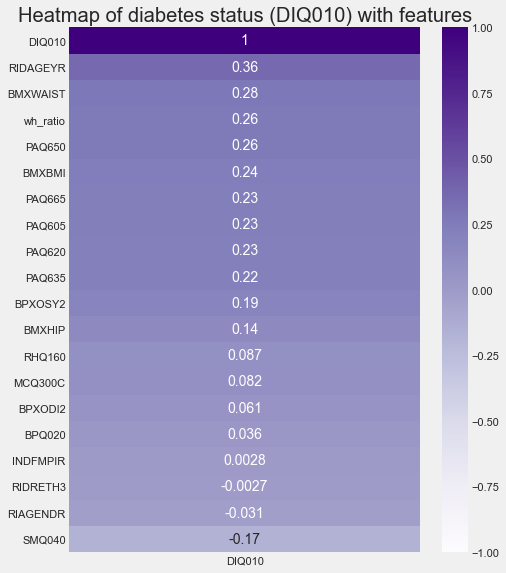

In [78]:
# heatmap of features with outcome column
corr_matrix = df.corr()

fig, ax = plt.subplots(figsize=(7,9))
ax.set_title('Heatmap of diabetes status (DIQ010) with features')
sns.heatmap(corr_matrix[['DIQ010']].sort_values(by = 'DIQ010',ascending = False),
            annot = True,
            vmin = -1,
            vmax = 1,
            cmap = 'Purples');

 ##### Heatmap Interpretation:

        - Age, waist-hip ratio, waist and hip measurements, BMI, and blood pressure have a positive correlation with diabetes. 



> ### Pairplot

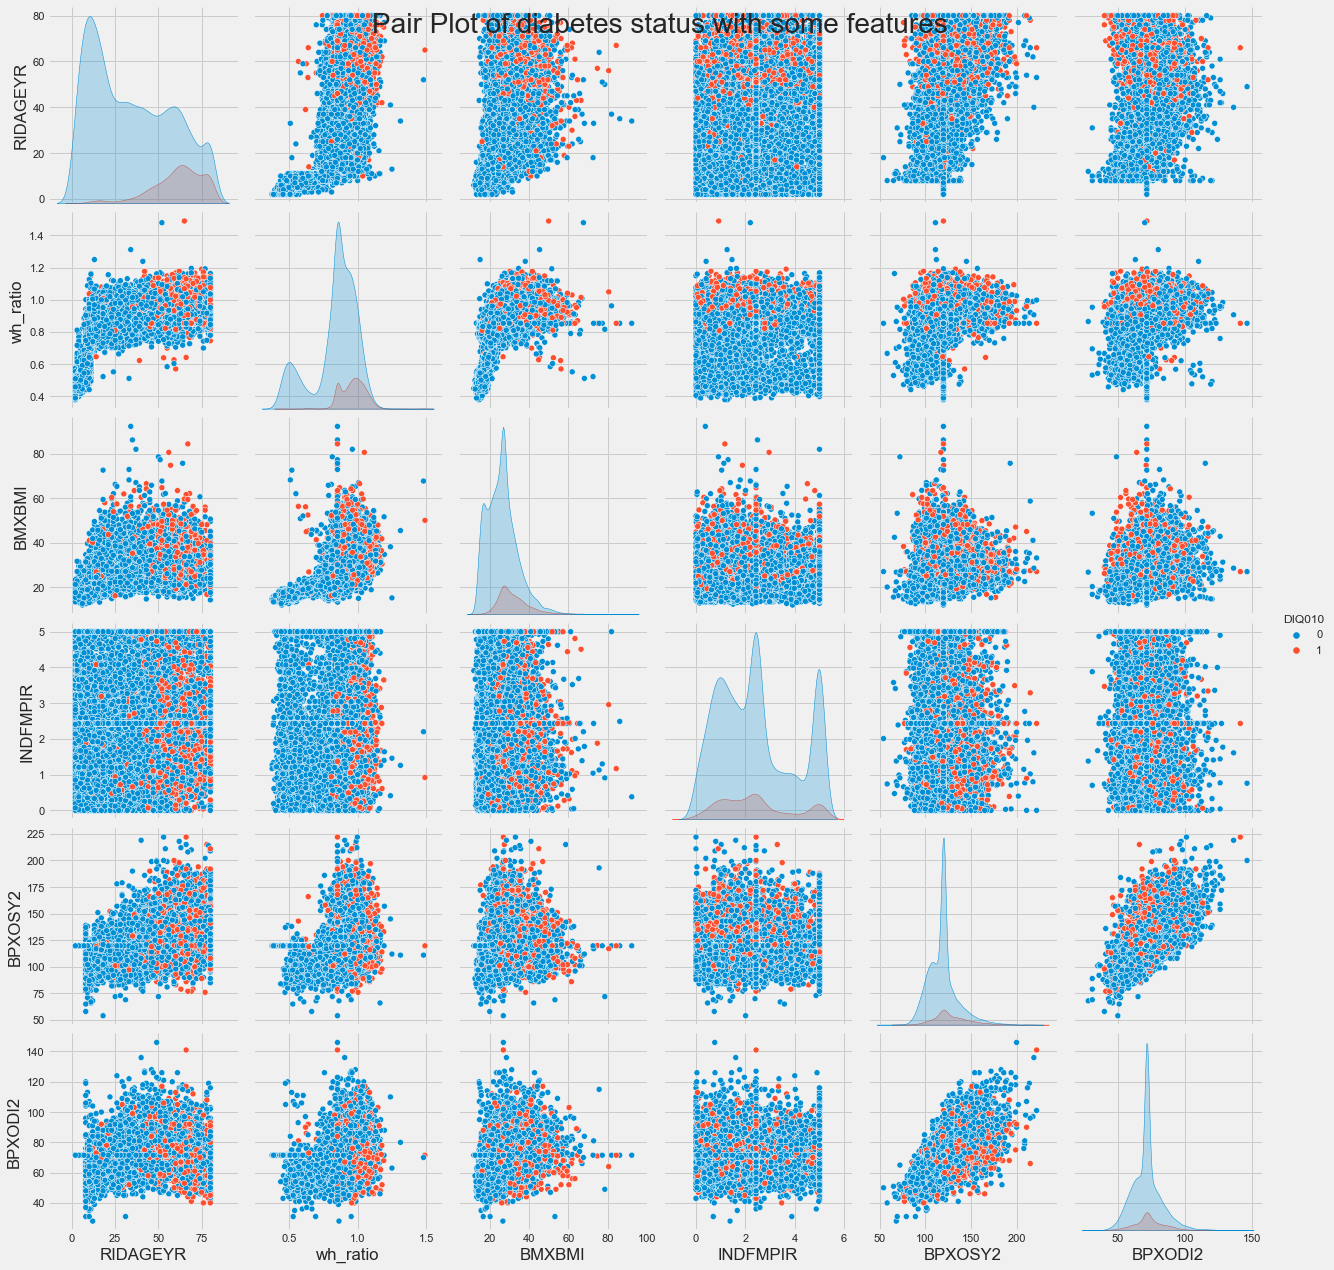

In [79]:
# distribution of numerical columns in relation to the outcome column
sns.pairplot(df, 
             vars = ['RIDAGEYR', 'wh_ratio', 'BMXBMI', 'INDFMPIR','BPXOSY2', 'BPXODI2'], 
             hue = 'DIQ010', 
             height = 3);
# title 
plt.suptitle('Pair Plot of diabetes status with some features', 
             size = 28);

+ ##### Pairplot interpretation:
        - BMI distribution is skewed to the left. Systolic and diastolic blood pressures have a normal distribution.
        - A higher number of respondents with diabetes are 45 and older. But there are outliers; a few respondents of age 25 and younger have diabetes. 
        - A higher number of diabetic respondents have a wh_ratio above 0.75.
        - wh_ratio and BMI show a pattern which is expected as this body measurements can be indicative of one another.

## Distribution of the data

#### 1. Outcome - Diabetes Status

In [80]:
# We'd expect the target column classes to be 50-50 yes and no responses
df.DIQ010.value_counts(normalize=True)

0    0.873674
1    0.126326
Name: DIQ010, dtype: float64

    - The class distribution in the outcome column are not what we expected. There is a class imbalance; the positive class makes up only 12%

#### 2. Pedigree

- Diabetes is a hereditary disease so we want to look at family history.
- MCQ300C feature represents diabetes status of respondent's close relatives. We would expect that respondents whose close relatives are diabetic to also be diabetic.

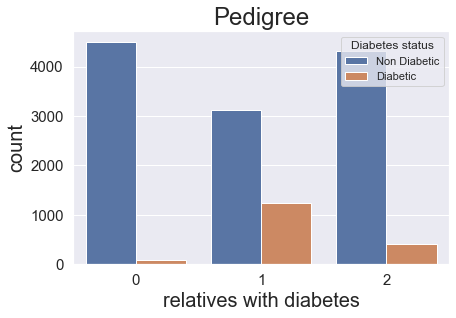

In [81]:
# relatives with diabetes Vs diabetes diagnosis of individuals 
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="MCQ300C", hue="DIQ010", data=df)
ax.set_xlabel('relatives with diabetes',fontsize=20);
ax.set_ylabel('count',fontsize=20);
ax.set_title('Pedigree', size =24)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(title='Diabetes status', loc='upper right', labels=['Non Diabetic', 'Diabetic'])
plt.show()


+ ##### Interpretation: 

    - A higher number of respondents who have close relatives who are diabetic, are themselves diabetic. This is shown in the plot with the middle bar. 
    - The number of Participants with no known diabetic close relative, who are also diabetic are low compared to the ones with diabetic close relatives. 
    - This is what we have expected in the data since diabetes is a hereditary disease.

#### 3. High blood Pressure

<AxesSubplot:xlabel='DIQ010', ylabel='BPXOSY2'>

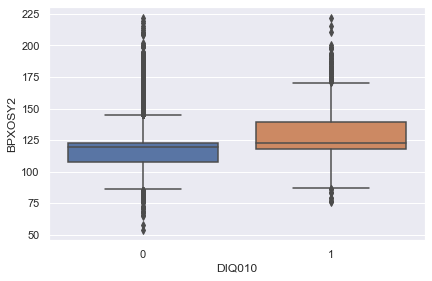

In [82]:
# plot of systolic blood pressure with diabetes
sns.boxplot(x='DIQ010', y='BPXOSY2', data=df)

<AxesSubplot:xlabel='DIQ010', ylabel='BPXODI2'>

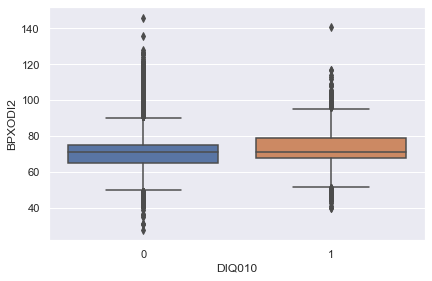

In [83]:
# plot of diastolic blood pressure with diabetes
sns.boxplot(x='DIQ010', y='BPXODI2', data=df)

Diabetic respondents have a higher systolic and dystolic blood pressure

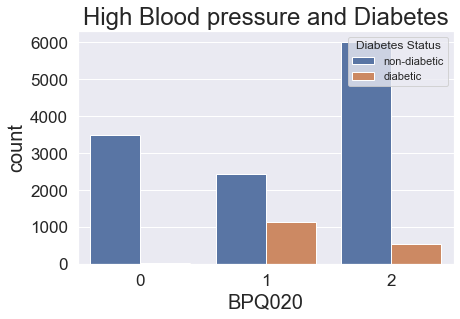

In [84]:
# High blood pressure diagnosis with diabetes status
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="BPQ020", hue="DIQ010",data=df)

ax.set_xlabel('BPQ020',fontsize=20);
ax.set_ylabel('count',fontsize=20);
ax.set_title('High Blood pressure and Diabetes', size =24)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title='Diabetes Status', loc='upper right', labels=['non-diabetic', 'diabetic'])
plt.show()

There are respondents with high blood pressure both for the diabetic and non-diabetic class in the data. There are no diabetic Participants from class 0 (who refused to respond - BPQ020)

#### Body Measures

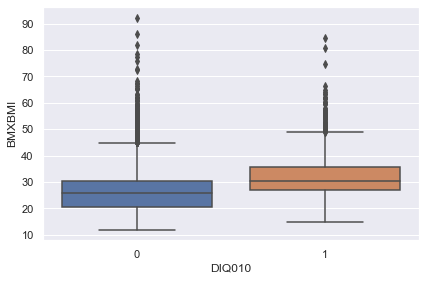

In [85]:
# plot of BMI with diabetes status
sns.boxplot(x="DIQ010", y="BMXBMI", data=df);

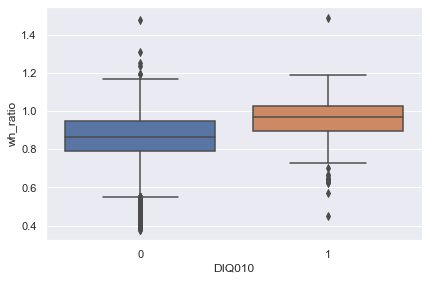

In [86]:
sns.boxplot(x="DIQ010", y='wh_ratio', data=df);

#### 4. Smoking

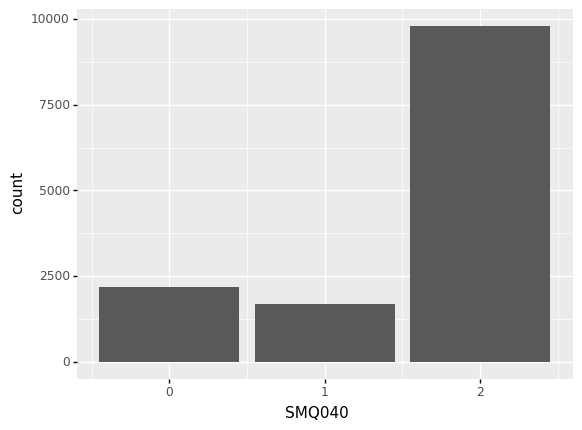

<ggplot: (8762190479357)>

In [87]:
# plot of number of diabetic people based on their smoking status
ggplot(data = df, mapping = aes(x = 'SMQ040', fill = 'DIQ010')) + geom_bar()

#### 5. Gender

In [88]:
# We'd expect the genders to be around 50-50 M/F
df.RIAGENDR.value_counts(normalize=True)

2    0.508887
1    0.491113
Name: RIAGENDR, dtype: float64

    + gender classes are balanced as we expected

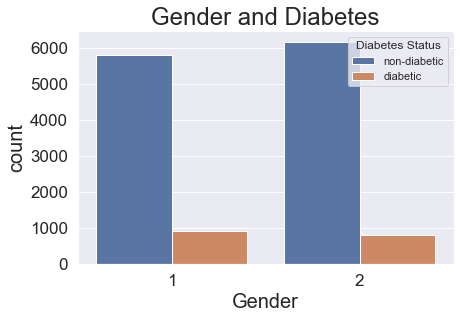

In [89]:
# race distribution with diabetes status
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="RIAGENDR", hue="DIQ010",data=df)

ax.set_xlabel('Gender',fontsize=20);
ax.set_ylabel('count',fontsize=20);
ax.set_title('Gender and Diabetes', size =24)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title='Diabetes Status', loc='upper right', labels=['non-diabetic', 'diabetic'])
plt.show()

 #### 6. Race

We would expect all races will have equal representation.


            1   Mexican American   2   Other Hispanic 3	Non-Hispanic White     4	Non-Hispanic Black  
            6	Non-Hispanic Asian  7	Other Race (Including Multi-Racial)

In [90]:
df.RIDRETH3.value_counts(normalize=True)

3    0.338234
4    0.266038
1    0.125667
6    0.110014
2    0.096847
7    0.063199
Name: RIDRETH3, dtype: float64

> ##### Interpretation: 
We have uneven distribution of race. non-hispanic white makeup one third of respondents, followed by non-hispanic black making up one fourth of the respondents. Multi racial has the least number of representation. 

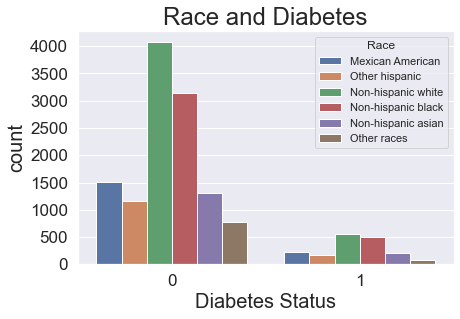

In [91]:
# race distribution with diabetes status
sns.set_theme(style="darkgrid")
ax = sns.countplot(hue="RIDRETH3", x="DIQ010",data=df)

ax.set_xlabel('Diabetes Status',fontsize=20);
ax.set_ylabel('count',fontsize=20);
ax.set_title('Race and Diabetes', size =24)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title='Race', loc='upper right', labels=['Mexican American', 'Other hispanic', 'Non-hispanic white', 'Non-hispanic black', 'Non-hispanic asian', 'Other races'])
plt.show()

#### 7. Number of Pregnancies

In [92]:
df_women= df[df.RIAGENDR == 2]
preg=df_women.groupby(by=['RHQ160']).sum()

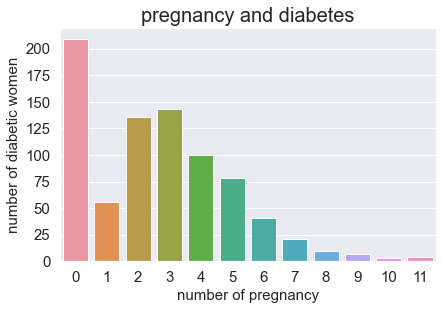

In [93]:
# plot of pregnancies count vs diabetes
ax = sns.barplot(x=preg.index, y="DIQ010", data=preg)

ax.set_xlabel('number of pregnancy',fontsize=15);
ax.set_ylabel('number of diabetic women',fontsize=15);
ax.set_title('pregnancy and diabetes', size =20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()


Distribution is skewed to the left. Women with zero pregnancies have the highest number of diabetic respondents. Number of pregnancies of three and two have the highest number of diabetic women.

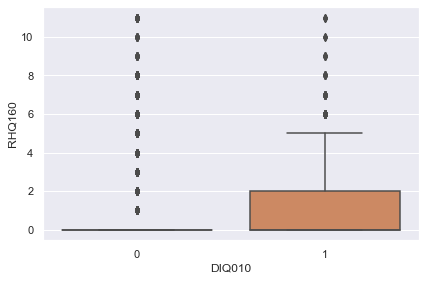

In [94]:
# create box plot 
sns.boxplot(x='DIQ010', y ='RHQ160',data=df)
plt.show()

#### Physical Activity

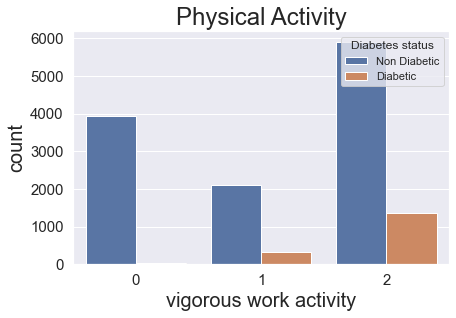

In [95]:
# relatives with diabetes Vs diabetes diagnosis of individuals 
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="PAQ605", hue="DIQ010", data=df)
ax.set_xlabel('vigorous work activity',fontsize=20);
ax.set_ylabel('count',fontsize=20);
ax.set_title('Physical Activity', size =24)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(title='Diabetes status', loc='upper right', labels=['Non Diabetic', 'Diabetic'])
plt.show()

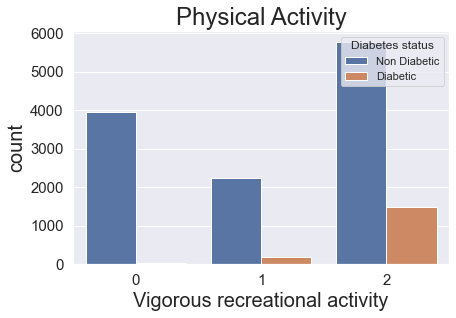

In [96]:
# relatives with diabetes Vs diabetes diagnosis of individuals 
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="PAQ650", hue="DIQ010", data=df)
ax.set_xlabel('Vigorous recreational activity',fontsize=20);
ax.set_ylabel('count',fontsize=20);
ax.set_title('Physical Activity', size =24)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(title='Diabetes status', loc='upper right', labels=['Non Diabetic', 'Diabetic'])
plt.show()

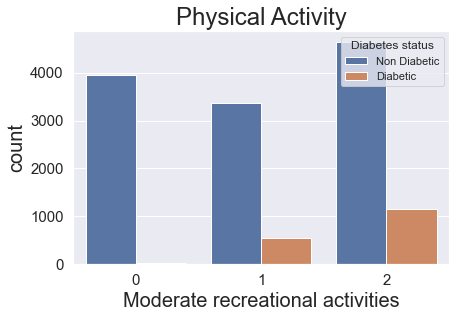

In [97]:
# relatives with diabetes Vs diabetes diagnosis of individuals 
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="PAQ665", hue="DIQ010", data=df)
ax.set_xlabel('Moderate recreational activities',fontsize=20);
ax.set_ylabel('count',fontsize=20);
ax.set_title('Physical Activity', size =24)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(title='Diabetes status', loc='upper right', labels=['Non Diabetic', 'Diabetic'])
plt.show()

### Summary of Analysis
___
 ##### Distribution of the data

1. Outcome Variable: The class distribution in the outcome column are not what we expected. There is a class imbalance; the positive class makes up only 12%
2. Pedigree

    - Comparing to participants with no known close relative who is diabetic, respondents with diabetic close relatives and who themselves are diabetic is three times the number. 
  
    - This is what we have expected since diabetes is a hereditary disease.
3. Gender: approximately 50 50 - its well balanced.

4. Race: We have uneven distribution of race. non-hispanic white makeup one third of respondents, followed by non-hispanic black making up one fourth of the respondents. Multi racial has the least number of representation. 

5. age: A higher number of respondents with diabetes are 45 and older. But there are outliers; a few respondents of age 25 and younger have diabetes. 

6. Body measures: BMI, wh_ratio: Diabetic class has a higher median value for BMI and wh_ratio as we expected. BMI of 30 for diabetic and BMI of 25 for non-diabetic 

7. blood pressure: Diabetic respondents have a higher systolic and dystolic blood pressure. There are more number of participants who diabetes and high blood pressure and diabetes comparing to people with no high blood pressure. 

8. physical activity: The number of diabetic people who do not do any physical activity be it at work or recreational, is higher than diabetic people who do some kind of physical activity.

11. number of pregnancies: Distribution is skewed to the left. Women with zero pregnancies have the highest number of diabetic respondents. Number of pregnancies of three and two have the highest number of diabetic women.

12. smoking: smoking data is imbalanced. we have 5X more respondents who are non-smokers and diabetic comparing to smokers and diabetic.

---

##### Potential predictive variables:

We will use these variables to predict diabetes.

    - age in years
    - BMI
    - wh_ratio
    - blood pressure
    - physical activity 
    - race
    - number of pregnancies
    - pedigree

    

Please go to Notebook 2: Modeling 